# <span style="color:deepskyblue; font-weight:bold;">Recap</span>

<div style="text-align: justify;">
In the previous notebook, we analyzed our population in order to create clusters and then to test them with a metric. The objective of this chapter is to develop two models on each segment and compare them with a single one. We are assuming that there is an already-developed-trunk model on the entire population with the aim of having a solid benchmark. This will be important to give value to the business and to realize if the segmentation was well performed. On the same page, we have two left questions to answer, these are the following ones:
</div>

* How do granular models perform better than a single one?
* What added value does having more than a model provide to the business?

# Notebook Initialization

Importing libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import warnings

from category_encoders.woe import WOEEncoder
from constants.categories import category_profession
# libraries configuration
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

ModuleNotFoundError: No module named 'constants'

Reading segmented dataframe and getting initial information

In [ ]:
# getting data from csv file
data = pd.read_csv('datasets/segmented_universe.csv', sep = ",")

# showing top 5
data.head()

,CODMES,CODSOLICITUD,DEUDA,PLAZO_CREDITO,FLG_GARANTIA,MIN_MES_DE_DEFAULT,FLG_DEFAULT_12M,SEGMENTOCLIENTE,TARJETA_RELACIONADA,VEHICULAR_RELACIONADA,HIPOTECARIO_RELACIONADA,ATRASO_MAXIMO_ULT_6M,ATRASO_MAXIMO_ULT_12M,ATRASO_MAXIMO_ULT_24M,MESES_AHORROS_ULT_6M,MEDIANA_AHORROS_ULT_6M,DEUDA_TOTAL_SISTEMA,CLASIF_SISTEMA_ULT_12M,FLG_PDH,NUMERO_DE_PAGOS_PDH,MONTO_TC_SISTEMA,INGRESO_CLIENTE,PROFESION,ZONA_DEL_DESEMBOLSO,ESTADO_CIVIL,EDAD_T,CUOTA,LINEA_DE_TC,MONTO_TC_MEMBRESIA,FLG_TC_VISA,FLG_TC_MC,FIXED_CLUSTER
0,201402,1,7116.681318,48,0,NaN,0,CLIENTES ORO,1,0,0,0,0.0,0.0,6.0,3772.486272,5450.35,0.0,1,24,4067.03,2526.246600,INGENIERO,UCAYALI,SOL,26.0,236.983971,5600.0,170.0,0.0,0.0,CORPUS
1,201404,2,1616.555000,60,0,NaN,0,CLIENTES ORO,1,0,0,0,0.0,0.0,6.0,8389.745000,0.00,0.0,1,24,0.00,2895.761372,TECNICO,AREQUIPA,CAS,49.0,62.089650,19250.0,170.0,0.0,0.0,CORPUS
2,201403,3,8082.775000,48,0,NaN,0,CLIENTES ORO,1,0,0,0,0.0,0.0,6.0,1842.695000,0.00,0.0,1,13,0.00,1474.419056,INGENIERO DE MINAS,PUNO,SOL,33.0,22.894893,10900.0,80.0,0.0,0.0,CORPUS
3,201307,4,10186.990760,48,0,201403.0,1,CLIENTES ORO,0,0,0,0,0.0,0.0,6.0,4514.070000,5661.25,0.0,1,24,0.00,1992.756892,TECNICO,CUZCO,SOL,25.0,244.267800,10900.0,80.0,0.0,0.0,CORPUS
4,201401,5,10777.033330,48,0,NaN,0,CLIENTES PLATINUM SEGM 2,1,0,0,0,0.0,0.0,6.0,7848.908333,0.00,0.0,1,6,0.00,1680.938223,TEC MECANICO AUTOMOTRIZ,LIMA_ESTE,CAS,57.0,17.430000,16300.0,170.0,0.0,0.0,PEAK


# <span style="color:#FF6600; font-weight:bold;">Fourth Question:</span> <span style="color:#6699CC;">How do granular models perform better than a single one?</span>

This section is quite complex because we need to generate our pre-existed benchmark, then we have to create two models on two segments. As a first step we are going to create a model on the entire universe. We are no tuning inasmuch as it is not the scope of the project, it is just to create some views part of the EDA development.

## <span style="color:lightcoral; font-weight:bold;"> Benchmark Developement:</span> <span style="color:deepskyblue;">Single Model</span>

This part has nothing to do with the clusters, it is just to develop a model on the whole universe, we need to preprocess features and to fit them into a model. As it was explained before, we are not going to each step a model should go, for instance, the tuning section.

We should see how the RD12 behaves and the materiality

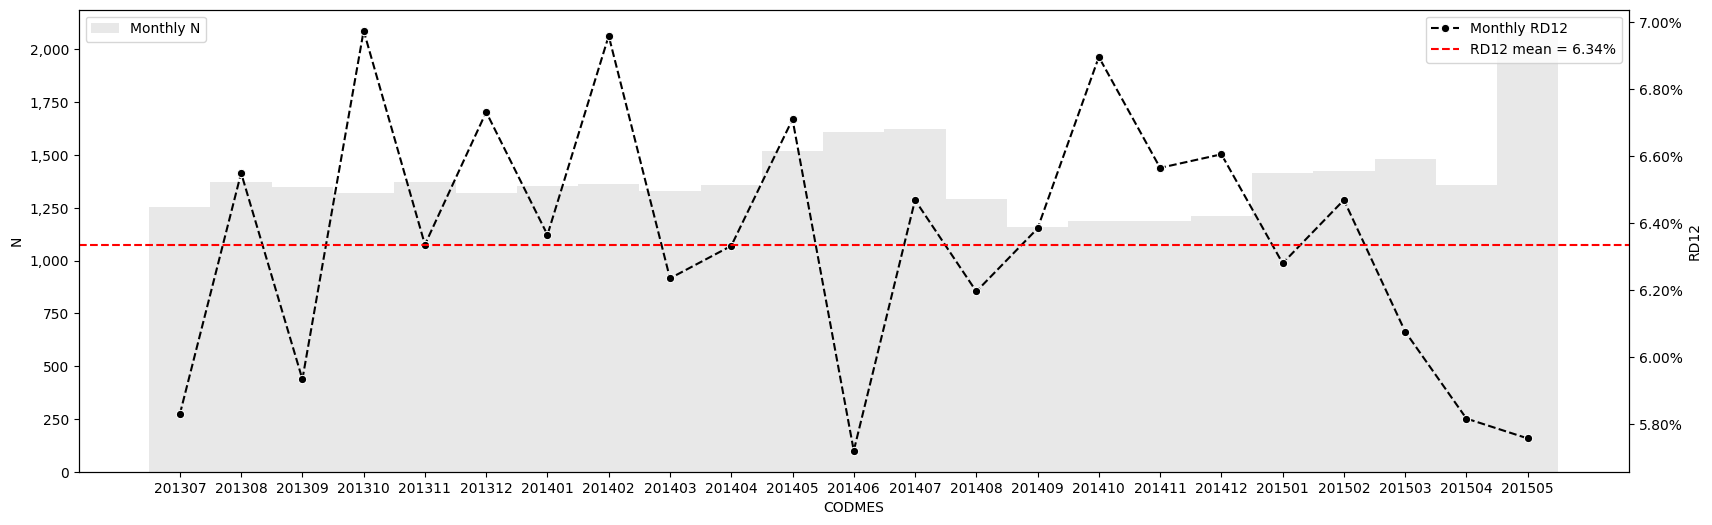

In [ ]:
group = data.groupby('CODMES', as_index = False)\
            .agg({'CODSOLICITUD': 'count',
                  'FLG_DEFAULT_12M': 'mean'})\
            .sort_values(by = 'CODMES')\
            .rename(columns = {'CODSOLICITUD': 'N',
                               'FLG_DEFAULT_12M': 'RD12'})

group['CODMES_NUM'] = range(len(group))
# get rd mean
rd_mean = data['FLG_DEFAULT_12M'].mean()

# declare subplots
fig, axis = plt.subplots(figsize = (20, 6))

# create N plot
sns.barplot(data = group,
            x = 'CODMES_NUM',
            y = 'N',
            width = 1,
            color = '#D3D3D3',
            alpha = 0.5,
            label = 'Monthly N',
            ax = axis)

# create second y axis
axis_rd = axis.twinx()

# create RD12 plot
sns.lineplot(data = group,
             x = 'CODMES_NUM',
             y = 'RD12',
             color = 'black',
             marker = 'o',
             label = 'Monthly RD12',
             ls = '--',
             ax = axis_rd)

# plot RD12 mean
axis_rd.axhline(rd_mean, color = 'red', ls = '--', label = f'RD12 mean = {rd_mean:.2%}')
# format data
axis.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))
axis_rd.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:.2%}'))
# set labels
axis.set_xlabel('CODMES')
axis.set_xticks(range(len(group)))
axis.set_xticklabels(group['CODMES'])

plt.legend()
plt.show()

<span style="color:#D8B0E5; font-weight:bold;">Observations:</span>

* It can be appreciated that the N value is uniform until 201504, which means most of the data is stable in terms of observations. Last month could be used as "Out of Time" set, in fact, last three months would be useful because RD12 is decreasing. Evaluating on a low default set could challenge a lot our model.

* RD12 behaves as expected, it does not vary a lot regarding its mean on the entire universe, its values go from 5.80% to 7%, which also calls the attention to verify how much imbalaced our target is.

It is well-known that credit risk models tend to have their target imbalanced. We should check on it in order observe the materiality

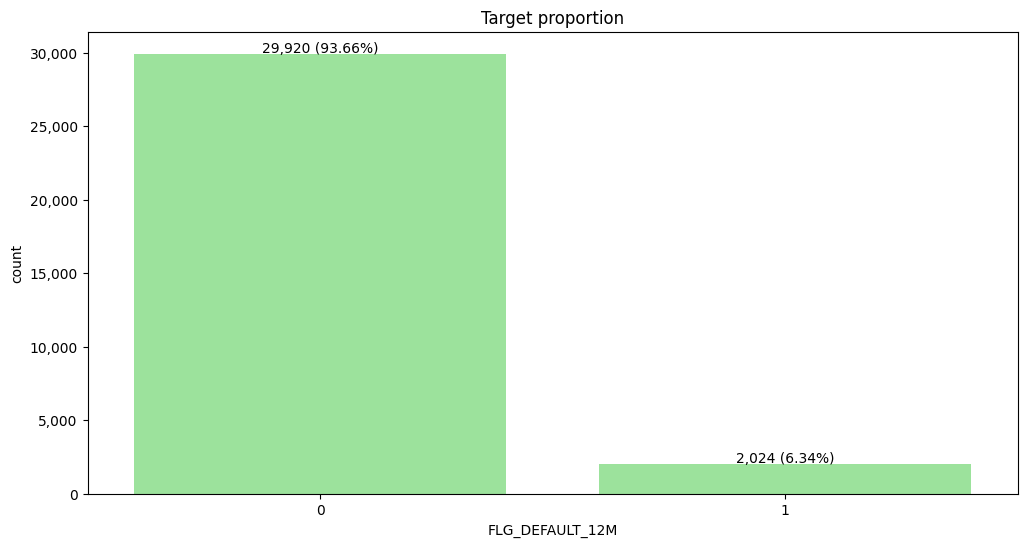

In [ ]:
# create figure
plt.figure(figsize = (12, 6))

# counplot
ax = sns.countplot(data = data,
                   x = 'FLG_DEFAULT_12M',
                   color = 'lightgreen')
# display proportions
target = data['FLG_DEFAULT_12M'].value_counts().to_dict()
target_per = {key: value / (sum(target.values())) for key, value in target.items()}

for x_pos in target.keys():
    plt.text(x = x_pos,
             y = target[x_pos] + 100,
             s = f'{target[x_pos]:,.0f} ({target_per[x_pos]:.2%})',
             ha = 'center')
# set title
ax.set_title('Target proportion')
# set format y axis
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))

plt.show()

<span style="color:#D8B0E5; font-weight:bold;">Observations:</span>

* As we saw in the preovious plot, the target is imbalaced, this might be a drawback when we have to develop the two left models beacuse we will reduce the materiality, having 2k samples of the target on the entire universe makes analyze that this point would be a future problema, but in terms of creating a single model, it should not be a problem.

* We are not oversampling our population, this approach uses balanced ensemble methods to handle this inconvenient.

Afterall, We have realized that our N and target is quite stable along months, however, target is pretty imbalanced on the entire dataset in terms of materiality, which could be a problem when splitting the universe. It is time to start modelling, we initiate counting unique values of categorical features, if they are greater than 15, we need to replace the categories.

In [ ]:
# declare a dataset for analysis
features_to_remove = ['CODMES', 'FIXED_CLUSTER']
data_analysis = data.drop(columns = features_to_remove)

# show describe
display(data_analysis.describe(include = object))

,SEGMENTOCLIENTE,PROFESION,ZONA_DEL_DESEMBOLSO,ESTADO_CIVIL
count,31944,31604,30954,30954
unique,7,175,30,6
top,CLIENTES ORO,TECNICO,AREQUIPA,SOL
freq,22101,10980,3664,21258


"PROFESION" and "ZONA_DEL_DESEMBOLSO" have too many unique values, before dropping them, we could regroup theri categories

In [ ]:
data_analysis.ZONA_DEL_DESEMBOLSO.unique()

array(['UCAYALI', 'AREQUIPA', 'PUNO', 'CUZCO', 'LIMA_ESTE',
       'LIMA_MODERNA', 'LIMA_CENTRO', 'LIMA_NORTE', 'JUNIN', 'ICA',
       'ANCASH', 'LA_LIBERTAD', 'TACNA', 'MOQUEGUA', nan, 'PIURA',
       'CALLAO', 'LIMA_SUR', 'AYACUCHO', 'AMAZONAS', 'APURIMAC',
       'LIMA_PROV', 'CERRO_DE_PASCO', 'LORETO', 'CAJAMARCA', 'LAMBAYEQUE',
       'HUANUCO', 'SAN_MARTIN', 'TUMBES', 'HUANCAVELICA', 'MADRE_DE_DIOS'],
      dtype=object)

In [ ]:
len(category_mapping)

175

In [ ]:
chow = data_analysis.PROFESION.unique()
low = list(category_mapping.keys())

pow = set(chow) - set(low)
pow

{nan}